In [6]:
import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM
from advertorch.attacks import LinfSPSAAttack
from src.trainers import Trainer, FGSMTrainer
from src.utils import adversarial_accuracy, fgsm_, pgd_, plot_along_grad_n
from src.Nets import CIFAR_Wide_Res_Net, CIFAR_Res_Net, CIFAR_Net, CUREResNet18
from src.gradient_masking_tests import run_masking_benchmarks, get_accuracy, pgd_colinearity
%load_ext autoreload
%autoreload 2
%aimport src.Nets, src.trainers, src.gradient_masking_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# setup
device = torch.device("cpu")
batch_size = 16
# remove the normalize
transform = transform = transforms.Compose(
            [transforms.ToTensor()]
)
        
normalized_min = (0 - 0.5) / 0.5
normalized_max = (1 - 0.5) / 0.5
train_dataset = datasets.CIFAR10(root='../data', train=True,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='../data', train=False,
                               download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)
classes = classes = ('plane', 'car', 'bird', 'cat',
   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
model = CIFAR_Res_Net().eval().to(device)
model.load_state_dict(torch.load("../models/normal_20e.model", map_location=device))
fgsm_model = CIFAR_Res_Net().eval().to(device)
fgsm_model.load_state_dict(torch.load("../models/fgsm_e16_20e.model", map_location=device))
fgsm_model_small = CIFAR_Res_Net().eval().to(device)
fgsm_model_small.load_state_dict(torch.load("../models/fgsm_e8_20e.model", map_location=device))
step_ll_model = CIFAR_Res_Net().eval().to(device)
step_ll_model.load_state_dict(torch.load("../models/step_ll_e16_20e.model", map_location=device))
step_ll_model_small = CIFAR_Res_Net().eval().to(device)
step_ll_model_small.load_state_dict(torch.load("../models/step_ll_e8_20e.model", map_location=device))
pgd_model = CIFAR_Res_Net().eval().to(device)
pgd_model.load_state_dict(torch.load("../models/pgd_e16_20e.model", map_location=device))
pgd_model_small = CIFAR_Res_Net().eval().to(device)
pgd_model_small.load_state_dict(torch.load("../models/pgd_e8_20e.model", map_location=device))
grad_reg_model = CIFAR_Res_Net().eval().to(device)
grad_reg_model.load_state_dict(torch.load("../models/grad_reg_ld01_20e.model", map_location=device))
cure = CUREResNet18().to(device).eval()
cure[1].load_state_dict(torch.load("../models/RN18_CURE.pth", map_location=device)['net'])

<All keys matched successfully>

## Plotting along gradient direction
#### This notebook takes a model and:
- #### selects 50 datapoints at random from the dataset
- #### finds the gradient direction for each of these datapoints w.r.t the loss
- #### plots the loss value along that direction for each datapoint

Normal model, following the direction of gradient is a good way to increase the loss

Below this, with predicted class instead of true class

1
2


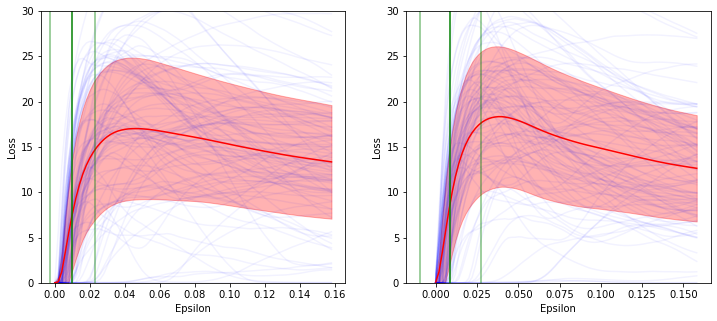

In [25]:
plot_along_grad_n(model, [train_dataset, test_dataset], 16, 100, device=device)

FGSM model large epsilon: following the gradient increases the loss only in the immediate neighbourhood. 

Its like we took the above behaviour and flattened it only for epsilon +- 0.06, which is the size of epsilon used for training

In this plot and all the further ones, in large epsilons we of course expect the loss to increase. This in principle has nothing to do with the defense used.

4
1


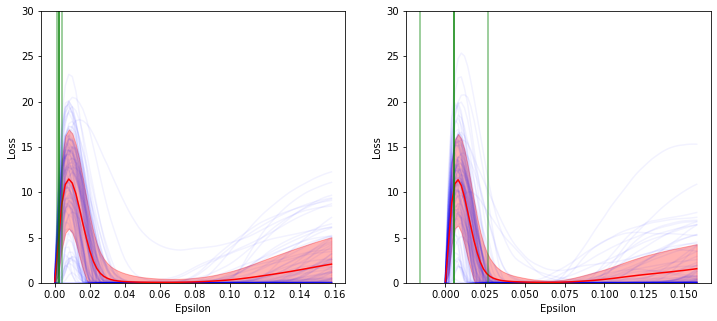

In [26]:
plot_along_grad_n(fgsm_model, [train_dataset, test_dataset], 16, 100, device=device)

Below this, with predicted class instead of true class

FGSM small epsilon: again, similar to above except the flattened region has been moved further up

14
16


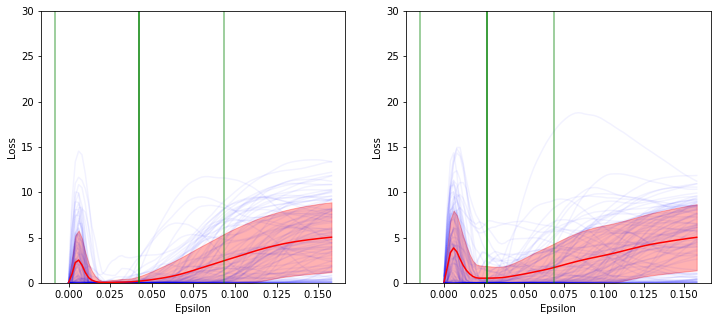

In [28]:
plot_along_grad_n(fgsm_model_small, [train_dataset, test_dataset], 16, 100, device=device)

Step-ll model large steps: Even locally, the gradient is now not a good direction to follow! Either there are no high loss regions within the epsilon neighbourhood (we know this is not true, as pgd and spsa both reveal them) OR the gradient really does provide no information for locating adv. examples.

34
17


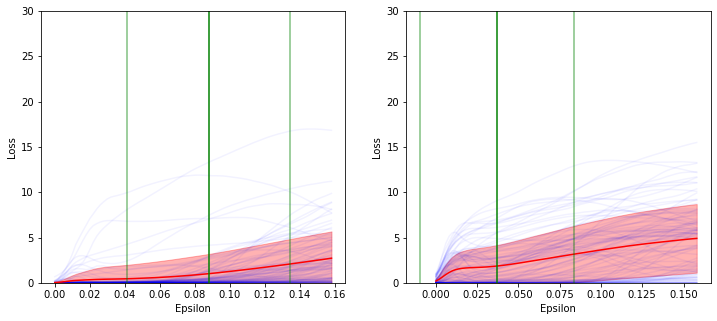

In [29]:
plot_along_grad_n(step_ll_model, [train_dataset, test_dataset], 16, 100, device=device)

Step ll model small eps: Its very interesting to compare this curve to the corresponding fgsm with small steps one. Im really not sure what the fundamental difference between both defences could be that causes such different loss surfaces to occur along the gradient direction

5
5


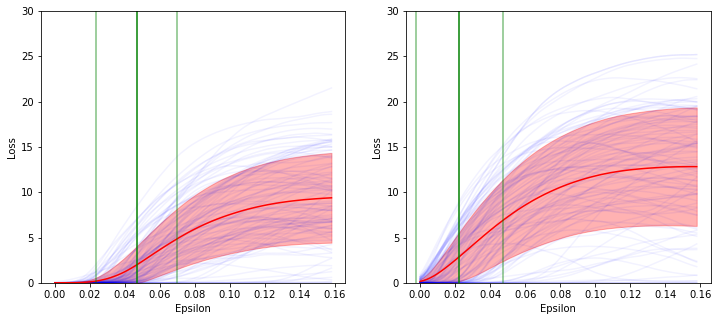

In [30]:
plot_along_grad_n(step_ll_model_small, [train_dataset, test_dataset], 16, 100, device=device)

pgd: the flattest response by far of all models. Very gradually increases as epsilon increases. SPSA numbers and general literature tell us there is no evidence of gradient masking. This is the "ideal" curve we expect?

15
18


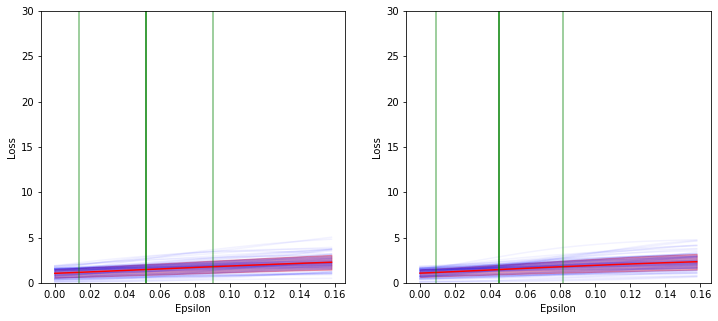

In [31]:
plot_along_grad_n(pgd_model, [train_dataset, test_dataset], 16, 100, device=device)

4
4


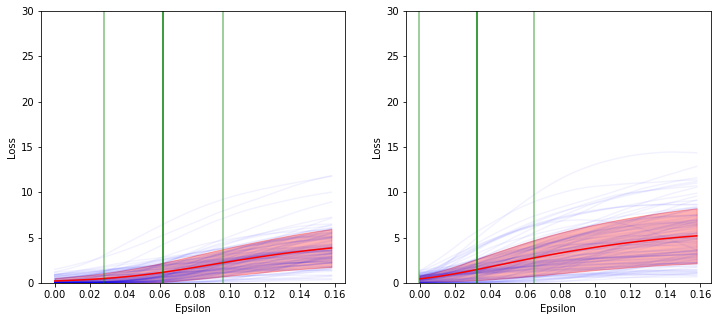

In [32]:
plot_along_grad_n(pgd_model_small, [train_dataset, test_dataset], 16, 100, device=device)

Grad reg and CURE show very similar curves, pointing to the similarities between both methods.

ValueError: only one element tensors can be converted to Python scalars

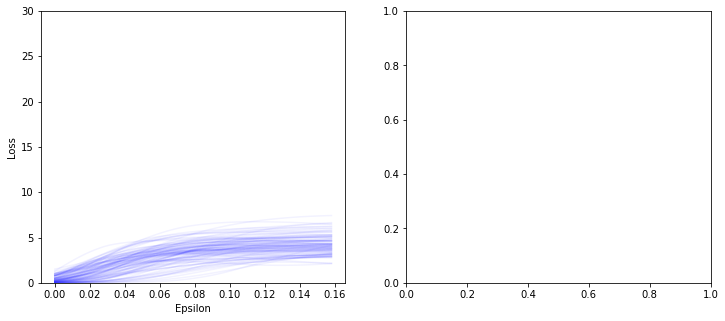

In [33]:
plot_along_grad_n(grad_reg_model, [train_dataset, test_dataset], 16, 100, device=device)

In [ ]:
plot_along_grad_n(cure, [train_dataset, test_dataset], 16, 100, device=device)